In [1]:
import torch
from torch import nn
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

from typing import Tuple, Dict, List
from collections import defaultdict

In [2]:
DEVICE = "cpu"

## Datasets

In [3]:
train_set = MNIST(root="./data",
                  train=True,
                 download=True,
                 transform=ToTensor(),
                 target_transform=None)
test_set = MNIST(root="./data",
                 train=False,
                 download=True,
                 transform=ToTensor())

In [4]:
def display_random_image(seed: int=None):
    if seed:
        random.seed(a=seed)
        torch.manual_seed(seed)
    plt.imshow(
        X=train_set[random.randint(0, b=len(train_set)-1)][0].reshape(28, 28, 1)
    )

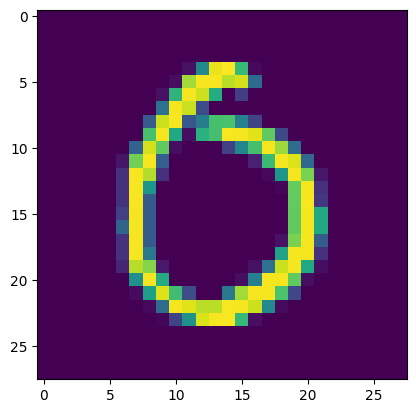

In [5]:
display_random_image(seed=43)

## Dataloaders

In [6]:
train_dataloader = DataLoader(dataset=train_set,
                              batch_size=64,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_set,
                             shuffle=False,
                             batch_size=64)

In [7]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

## Model

In [8]:
class DigitClassifier(nn.Module):
    
    def __init__(self):

        super().__init__()

        self.net = nn.Sequential(
            nn.Flatten(end_dim=-1),
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )
    
    def forward(self,
                X: torch.Tensor) -> float:
        return self.net(X)

## Training

In [9]:
def train_step(model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: DataLoader) -> Tuple[float]:
    
    model.train()
    model.to(DEVICE)
    train_loss, train_acc = 0, 0
    for X_batch, y_batch in dataloader:
        
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(y_pred, dim=-1).squeeze() == y_batch.squeeze()).item()/ 64
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)


    return train_loss, train_acc

@torch.no_grad()
def eval_step(model: nn.Module,
               loss_fn: nn.Module,
               dataloader: DataLoader) -> Tuple[float]:
    
    model.eval()
    model.to(DEVICE)
    eval_loss, eval_acc = 0, 0
    
    for X_batch, y_batch in dataloader:
        
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        eval_loss += loss.item()
        eval_acc += torch.sum(torch.argmax(y_pred, dim=-1).squeeze() == y_batch.squeeze()).item()/ 64
    
    eval_loss /= len(dataloader)
    eval_acc /= len(dataloader)


    return eval_loss, eval_acc

In [10]:
def train(model: nn.Module,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          epochs: int) -> Dict[str, List[float]]:
    
    
    results = defaultdict(list)

    for epoch in range(1, epochs+1):
        
        train_loss, train_acc = train_step(model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           dataloader=train_dataloader)
        test_loss, test_acc = eval_step(model=model,
                                        loss_fn=loss_fn,
                                        dataloader=test_dataloader)
        
        print(f"epoch {epoch} train_loss:{train_loss:.3f} train_acc:{train_acc} test_loss:{test_loss:.3f} test_acc:{test_acc}")
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
    
    return results

In [11]:
model = DigitClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=1e-2
)

In [12]:
results = train(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  epochs=10)

epoch 1 train_loss:1.678 train_acc:0.5698460820895522 test_loss:0.751 test_acc:0.8129976114649682
epoch 2 train_loss:0.546 train_acc:0.85559368336887 test_loss:0.417 test_acc:0.8817675159235668
epoch 3 train_loss:0.393 train_acc:0.8890758262260128 test_loss:0.347 test_acc:0.8979896496815286
epoch 4 train_loss:0.343 train_acc:0.9008695362473348 test_loss:0.315 test_acc:0.9041600318471338
epoch 5 train_loss:0.313 train_acc:0.9095482409381663 test_loss:0.290 test_acc:0.910031847133758
epoch 6 train_loss:0.291 train_acc:0.9151119402985075 test_loss:0.271 test_acc:0.9166998407643312
epoch 7 train_loss:0.271 train_acc:0.9215251865671642 test_loss:0.256 test_acc:0.9234673566878981
epoch 8 train_loss:0.254 train_acc:0.9260894189765458 test_loss:0.237 test_acc:0.9282444267515924
epoch 9 train_loss:0.239 train_acc:0.9310534381663113 test_loss:0.225 test_acc:0.9287420382165605
epoch 10 train_loss:0.224 train_acc:0.9350013326226013 test_loss:0.212 test_acc:0.9349124203821656


## Result Visualization

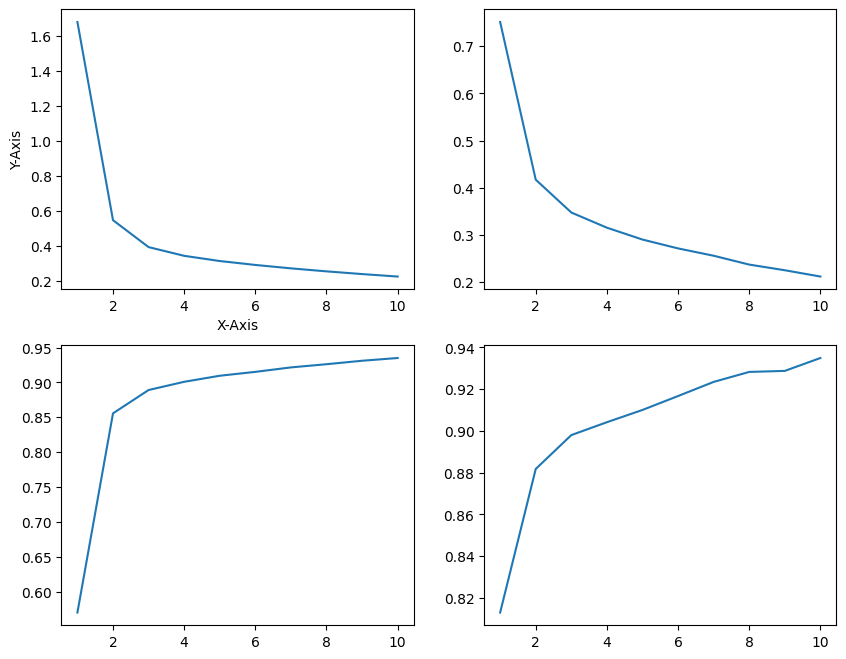

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot some data on each subplot
axs[0, 0].plot(np.arange(1, 11), results["train_loss"])
axs[0, 1].plot(np.arange(1, 11), results["test_loss"])
axs[1, 0].plot(np.arange(1, 11), results["train_acc"])
axs[1, 1].plot(np.arange(1, 11), results["test_acc"])

axs[0, 0].set_xlabel('X-Axis')
axs[0, 0].set_ylabel('Y-Axis')
plt.show()
fig.tight_layout()

## Saving Model

In [14]:
torch.save(obj=model.state_dict,
           f="./weights/simple_model.pt")